# Analisis Data reviews

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from langdetect import detect, DetectorFactory

ModuleNotFoundError: No module named 'textblob'

# Exploracion del Conjunto de Datos

## Exploracion General de los datos

Leemos el csv e imprimimos el archivo para validar que si este correcto el dataframe

In [78]:
#Lecura del archivo CSV
df_completo = pd.read_csv('../data/raw/reviews.csv', sep = ',', encoding = 'utf-8')

df = df_completo.head(10000).copy()
#Imrpimir las primeras filas del DataFrame
print(df.head())

   listing_id        id        date  reviewer_id reviewer_name  \
0    10257549  59265221  2016-01-08     31043833       Karolis   
1    10257549  59352234  2016-01-09      7248934         James   
2    10257549  59456981  2016-01-10     52707457        Manuel   
3    10257549  59661086  2016-01-13     52989229         Annie   
4    10257549  59806795  2016-01-15     51159033        Svenja   

                                            comments  
0  The flat is very nice newly renovated. The hos...  
1  Benito and his wife were great guests. Perfect...  
2  Fue algo express. No pude volar y contacté con...  
3  This was a very comfortable and conveniently l...  
4  Nice place, really close to te airport - Nice ...  


In [60]:
#Cantidad de columnas y filas
print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
print(f"El DataFrame completo tiene {df_completo.shape[0]} filas y {df_completo.shape[1]} columnas.")

El DataFrame tiene 1000 filas y 6 columnas.
El DataFrame completo tiene 1388226 filas y 6 columnas.


In [61]:
#Estructura del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     1000 non-null   int64 
 1   id             1000 non-null   int64 
 2   date           1000 non-null   object
 3   reviewer_id    1000 non-null   int64 
 4   reviewer_name  1000 non-null   object
 5   comments       1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB
None


## Análisis de las columnas tipo *object* (no numéricas)

Se realiza el análisis de las columnas categóricas y de texto con el fin de comprender su estructura y definir las transformaciones necesarias para su posterior procesamiento.  
  
Durante la revisión se identificaron los siguientes puntos relevantes:
- **Columna de fecha:** presentan el formato estándar `aaaa-mm-dd`, por lo que **no requiere transformación adicional**.
- **Columna de nombre:** al ser un nombre, no necesitamos normalizarlo. Como mucho solo es Capitalizar el texto.  
- **Columna de comentarios:** Hay comentarios en inglés y español, en este caso, haremos un análisis de sensibilidad pero no es necesario cambiar o normalizar nada. 

In [62]:
obj_cols = df.select_dtypes(include='object')
# Mostramos todas las columnas sin truncar
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
obj_cols.head(10)

,date,reviewer_name,comments
0,2016-01-08,Karolis,The flat is very nice newly renovated. The hos...
1,2016-01-09,James,Benito and his wife were great guests. Perfect...
2,2016-01-10,Manuel,Fue algo express. No pude volar y contacté con...
3,2016-01-13,Annie,This was a very comfortable and conveniently l...
4,2016-01-15,Svenja,"Nice place, really close to te airport - Nice ..."
5,2016-02-01,Ryan & Caitlin,We stayed at the house during a brief stay in ...
6,2016-02-07,Nikki,Great place to stay! The hosts were friendly ...
7,2016-02-09,Ian,Juana fue MUY amable y atenta con nosotros. Ll...
8,2016-02-13,Elise,Very nice apartment closed to the airport as d...
9,2016-02-15,Katie,Benito's place was very convenient to the airp...


## Análisis de las columnas tipo *number* general

Se realiza el mismo proceso de análisis que en las columnas no numéricas, pero enfocado en las variables de tipo numérico.  

En general, **no se identifican discrepancias** en los datos numéricos: los valores presentan solamente ids, por lo que es un dato de relación más que calificativo.


In [ ]:
df_num = df.select_dtypes(include=['number'])
pd.set_option('display.max_columns', None)  
display(df_num.head(10))

,listing_id,id,reviewer_id
0,10257549,59265221,31043833
1,10257549,59352234,7248934
2,10257549,59456981,52707457
3,10257549,59661086,52989229
4,10257549,59806795,51159033
5,10257549,61251387,4716480
6,10257549,61738556,53051726
7,10257549,61967208,48955065
8,10257549,62323327,36070015
9,10257549,62544677,30413204


## Análisis de valores nulos

Se verifica el porcentaje de valores nulos presentes en cada columna del conjunto de datos.  
Durante este análisis se observa que **la columna comments presenta menos del 0.01% de valores faltantes**, por lo que **se considera apropiado no eliminarlas**, dado que nos da un indicativo en cuanto a qué tan seguido dejan comentarios, ya sean buenos o malos calificando la publicación.

In [64]:
nulos = df.isnull().sum()
por_nulos   = (df.isnull().mean() * 100).round(2)
tabla = pd.concat([nulos, por_nulos], axis=1, keys=['Nulos', '%'])
df_nulos = tabla.sort_values(by='Nulos', ascending=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df_nulos)

               Nulos    %
listing_id         0  0.0
id                 0  0.0
date               0  0.0
reviewer_id        0  0.0
reviewer_name      0  0.0
comments           0  0.0


## Análisis de duplicados
No se eliminan los datos duplicados, ya que es normal que los inquilinos realicen comentarios genéricos, como "Bueno" o "Regular".
Este podría ser usado en un análisis para ver qué tan en serio se toman los reviews algunos inquilinos.

In [ ]:
# Conteo de filas duplicadas
total_duplicados = df.duplicated().sum()
print(f"\nTotal de filas duplicadas (considerando todas las columnas): {total_duplicados}")

# Analizar duplicados en la columna 'comments' (posibles comentarios idénticos)
duplicados_comments = df['comments'].duplicated().sum()
print(f"Total de comentarios duplicados (solo columna 'comments'): {duplicados_comments}")


Total de filas duplicadas (considerando todas las columnas): 0
Total de comentarios duplicados (solo columna 'comments'): 139


En una muestra de 10.000 reviews, hay 139 comentarios duplicados, no es un valor tan significativo pero representa más del 1%

## Detección de valores atípicos enb la puntuación de sentimiento
A pesar de que no hayan columnas como price o minimum_nights, podemos analizar los outliers en la Puntuación compuesta que acabamos de generar, ya que un outlier en sentimiento es relevante (Ejemplo: Un valor de -1.0 cuando la media es 0.8).

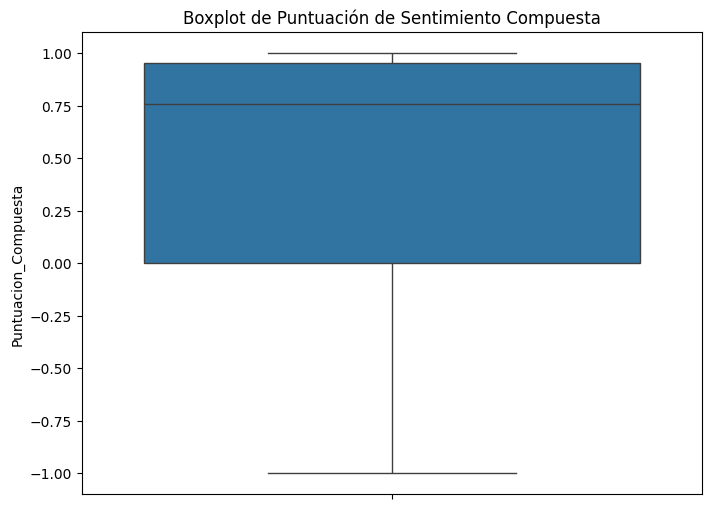

In [86]:
plt.figure(figsize=(8, 6))
# Boxplot de la Puntuación Compuesta
sns.boxplot(y=df['Puntuacion_Compuesta'])
plt.title('Boxplot de Puntuación de Sentimiento Compuesta')
plt.ylabel('Puntuacion_Compuesta')
plt.show()

### Resumen estadístico para identificar valores extremos

In [87]:
print("\nEstadísticas Descriptivas de Puntuacion_Compuesta:")
print(df['Puntuacion_Compuesta'].describe())


Estadísticas Descriptivas de Puntuacion_Compuesta:
count    10000.000000
mean         0.516954
std          0.451373
min         -1.000000
25%          0.000000
50%          0.760000
75%          0.952100
max          1.000000
Name: Puntuacion_Compuesta, dtype: float64


### Identificación de Outliers (con IQR)

In [88]:
# Identificación de Outliers (ejemplo con IQR)
Q1 = df['Puntuacion_Compuesta'].quantile(0.25)
Q3 = df['Puntuacion_Compuesta'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_negativos = df[df['Puntuacion_Compuesta'] < limite_inferior]
outliers_positivos = df[df['Puntuacion_Compuesta'] > limite_superior]

print(f"\nTotal de Outliers detectados (basado en IQR): {len(outliers_negativos) + len(outliers_positivos)}")
print(f"Ejemplo de un Outlier Negativo (Puntuación < {limite_inferior:.4f}):")
if not outliers_negativos.empty:
    print(outliers_negativos[['comments', 'Puntuacion_Compuesta', 'Sentimiento']].head(1).to_string(index=False))
else:
    print("No hay outliers negativos en esta muestra.")


Total de Outliers detectados (basado en IQR): 0
Ejemplo de un Outlier Negativo (Puntuación < -1.4282):
No hay outliers negativos en esta muestra.


# Clasificación de sentimientos (Inglés y Español)
Configuración de los recursos

In [65]:
# Configuración para reproducibilidad en langdetect
DetectorFactory.seed = 0
nltk.download('vader_lexicon')

# Descargar recursos de NLTK (si es la primera vez)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')

# Inicializar VADER (para inglés)
vader_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Función de clasificación multilingüe

Clasifica un comentario como 'Positivo', 'Neutral' o 'Negativo', detectando si es español o inglés.  
Umbrales de sensibilidad: Positivo >= 0.05, Negativo <= -0.05

In [66]:
def clasificar_sentimiento_multilingue_v2(comentario):
    if pd.isna(comentario) or str(comentario).strip() == "":
        return 'Neutral', 0.0

    comentario_str = str(comentario).strip()
    score = 0.0
    lang = 'unk' # Unknown language
    
    try:
        lang = detect(comentario_str)
    except Exception:
        # Si la detección falla (ej. comentario muy corto)
        lang = 'unk'

    try:
        if lang == 'en':
            # VADER para Inglés (compound score normalizado -1 a 1)
            vs = vader_analyzer.polarity_scores(comentario_str)
            score = vs['compound']
        elif lang == 'es':
            # TextBlob para Español (polarity score -1 a 1)
            # TextBlob funciona con un léxico básico para español sin necesidad de traducción
            score = TextBlob(comentario_str).sentiment.polarity
        else:
            # Si el idioma no es 'en' o 'es', o falla la detección, se asume neutral
            score = 0.0 
            
    except Exception:
        # Fallback si el análisis de sentimiento falla
        score = 0.0
    
    # Aplicar los umbrales de sensibilidad definidos (± 0.05)
    if score >= 0.05:
        sentimiento = 'Positivo'
    elif score <= -0.05:
        sentimiento = 'Negativo'
    else:
        sentimiento = 'Neutral'
        
    return sentimiento, score

## Aplicación al DataFrame
Más específicamente a la columna 'comments'

In [79]:
# Aplicar la función a la columna 'comments'
df[['Sentimiento', 'Puntuacion_Compuesta']] = df['comments'].apply(
    lambda x: pd.Series(clasificar_sentimiento_multilingue_v2(x))
)

# Imprimir las primeras filas con los resultados para verificar
print("DataFrame con la Clasificación Multilingüe de Sentimientos:")
print(df[['comments', 'Puntuacion_Compuesta', 'Sentimiento']].head(10))

DataFrame con la Clasificación Multilingüe de Sentimientos:
                                            comments  Puntuacion_Compuesta  \
0  The flat is very nice newly renovated. The hos...              0.917000   
1  Benito and his wife were great guests. Perfect...              0.938600   
2  Fue algo express. No pude volar y contacté con...              0.000000   
3  This was a very comfortable and conveniently l...              0.986300   
4  Nice place, really close to te airport - Nice ...              0.680800   
5  We stayed at the house during a brief stay in ...              0.955200   
6  Great place to stay!  The hosts were friendly ...              0.982600   
7  Juana fue MUY amable y atenta con nosotros. Ll...              0.260417   
8  Very nice apartment closed to the airport as d...              0.398100   
9  Benito's place was very convenient to the airp...              0.915300   

  Sentimiento  
0    Positivo  
1    Positivo  
2     Neutral  
3    Positivo  
4

## Análisis de sensibilidad (Distribución)

Conteo y porcentaje de cada categoría

In [81]:
conteo_sentimientos = df['Sentimiento'].value_counts()
porcentaje_sentimientos = df['Sentimiento'].value_counts(normalize=True) * 100

print("\nAnálisis de Sensibilidad: Distribución de Sentimientos")
print("-" * 60)
print("Conteo Total:")
print(conteo_sentimientos)
print("\nDistribución Porcentual:")
print(porcentaje_sentimientos.round(2).astype(str) + '%')


Análisis de Sensibilidad: Distribución de Sentimientos
------------------------------------------------------------
Conteo Total:
Sentimiento
Positivo    6107
Neutral     3805
Negativo      88
Name: count, dtype: int64

Distribución Porcentual:
Sentimiento
Positivo    61.07%
Neutral     38.05%
Negativo     0.88%
Name: proportion, dtype: object


## Visualización de distribución

C:\Users\User9\AppData\Local\Temp\ipykernel_27720\1294715864.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=porcentaje_sentimientos.index, y=porcentaje_sentimientos.values, palette=palette, order=['Positivo', 'Neutral', 'Negativo'])


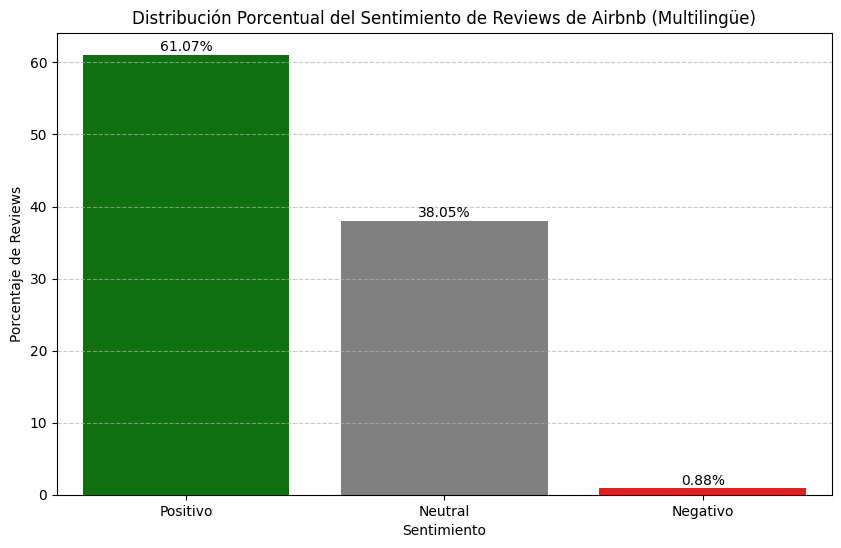

In [82]:
plt.figure(figsize=(10, 6))
# Definición de colores
palette = {'Positivo': 'green', 'Neutral': 'gray', 'Negativo': 'red'} 

# Crear el gráfico de barras
sns.barplot(x=porcentaje_sentimientos.index, y=porcentaje_sentimientos.values, palette=palette, order=['Positivo', 'Neutral', 'Negativo'])

# Añadir etiquetas de porcentaje a las barras
for index, value in enumerate(porcentaje_sentimientos.values):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')

plt.title('Distribución Porcentual del Sentimiento de Reviews de Airbnb (Multilingüe)')
plt.xlabel('Sentimiento')
plt.ylabel('Porcentaje de Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Revisión de los umbrales
Revisa cómo se comportan los comentarios clasificados como "Neutros".  
Si muchos tienen puntuaciones muy cercanas a los límites de 0.05 y -0.05,  
la clasificación es sensible a los cambios en el umbral.

In [84]:
print("\nAnálisis de Sensibilidad en los Márgenes:")
neutros = df[df['Sentimiento'] == 'Neutral']['Puntuacion_Compuesta']

if not neutros.empty:
    print(f"  Rango de Puntuaciones para 'Neutral' ({len(neutros)} comentarios):")
    print(f"  Puntuación Mínima (cercana a Negativo): {neutros.min():.4f} (El umbral es -0.05)")
    print(f"  Puntuación Máxima (cercana a Positivo): {neutros.max():.4f} (El umbral es 0.05)")
else:
    print("No hay comentarios 'Neutrales'.")


Análisis de Sensibilidad en los Márgenes:
  Rango de Puntuaciones para 'Neutral' (3805 comentarios):
  Puntuación Mínima (cercana a Negativo): -0.0333 (El umbral es -0.05)
  Puntuación Máxima (cercana a Positivo): 0.0367 (El umbral es 0.05)


# Conclusión
El dataset de muestra es de alta calidad en cuanto a la densidad de datos (pocas columnas, pocos nulos).  
No se maneja ningún tipo de transformación en los datos, no es necesario. Como mucho s etransformarían las columnas de fechas de tipo object a string para el guardado en base de datos sin generar errores.